
# Customer Segmentation and Classification for Online Retail
This notebook demonstrates the analysis of an online retail dataset from the UK(download from UCI Machine Learning repository). The main goals are:
1. **RFM**: Using RFM to score customers.
2. **Clustering**: Using K-Means to group customers into clusters based on their purchasing behavior.
3. **Classification**: Using K-Nearest Neighbors (KNN) to predict the cluster of new customers based on their data.



---


# Libraries

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV


C:\Users\asus\AppData\Roaming\Python\Python39\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.8.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
C:\Users\asus\AppData\Roaming\Python\Python39\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.4' currently installed).
  from pandas.core import (



### Loading the Dataset


In [2]:
df = pd.read_excel("Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## PreProcessing and Data Cleaning

In [3]:
#checking for null values 
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Remove rows where 'CustomerID' or 'Description' is missing, as these rows cannot be replaced meaningfully.
df.dropna(subset=['CustomerID', 'Description'], inplace=True)

# Verify there are no remaining null values in the dataset.
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [5]:
# Filter out canceled orders from the dataset by removing rows with negative 'Quantity' values.
# Negative quantities typically indicate returns or cancellations.
df = df[df['Quantity']>0]

In [6]:
# Remove rows with negative 'UnitPrice' values, This sort of values are not meaningful.
df = df[df['UnitPrice'] > 0]

In [7]:
# Remove duplicates rows.
df.drop_duplicates(inplace=True)

In [8]:
# Creat a copy of cleaned dataset.
df_copy = df.copy()

# RFM Analysis 

In [9]:
# Get the last transaction
df_copy.InvoiceDate.max()

Timestamp('2011-12-09 12:50:00')

## Recency

In [10]:
latest_date = dt.datetime(2011, 12, 10)


# Calculate recency for each customer by finding the date of their last purchase.
latest_purchase_date = df.groupby('CustomerID')['InvoiceDate'].max().reset_index()
latest_purchase_date.columns = ['CustomerID', 'LastPurchaseDate']


latest_purchase_date['Recency'] = (latest_date - latest_purchase_date['LastPurchaseDate']).dt.days
latest_purchase_date = latest_purchase_date[['CustomerID', 'Recency']]
latest_purchase_date

,CustomerID,Recency
0,12346.0,325
1,12347.0,2
2,12348.0,75
3,12349.0,18
4,12350.0,310
...,...,...
4333,18280.0,277
4334,18281.0,180
4335,18282.0,7
4336,18283.0,3


## Frequency

In [11]:
# Calculate the purchase frequency for each 'CustomerID'.
frequency_df = df_copy.groupby('CustomerID')['InvoiceNo'].count().reset_index()
frequency_df = frequency_df.rename(columns={'InvoiceNo': 'Frequency'})
frequency_df

,CustomerID,Frequency
0,12346.0,1
1,12347.0,182
2,12348.0,31
3,12349.0,73
4,12350.0,17
...,...,...
4333,18280.0,10
4334,18281.0,7
4335,18282.0,12
4336,18283.0,721


## Monetary

In [12]:
# Calculate Total amount for each row.
df_copy['TotalAmount'] = df_copy['UnitPrice']*df_copy['Quantity']

# Calculate the monetary value for each 'CustomerID'.
monetary_df = df_copy.groupby('CustomerID')['TotalAmount'].sum().reset_index()
monetary_df = monetary_df.rename(columns={'TotalAmount': 'Monetary'})
monetary_df

,CustomerID,Monetary
0,12346.0,77183.60
1,12347.0,4310.00
2,12348.0,1797.24
3,12349.0,1757.55
4,12350.0,334.40
...,...,...
4333,18280.0,180.60
4334,18281.0,80.82
4335,18282.0,178.05
4336,18283.0,2045.53


In [13]:
# merge these 3 data frames to have rfm data frame
rfm = pd.merge(latest_purchase_date, frequency_df, on='CustomerID') 
rfm = pd.merge(rfm, monetary_df, on='CustomerID')
rfm

,CustomerID,Recency,Frequency,Monetary
0,12346.0,325,1,77183.60
1,12347.0,2,182,4310.00
2,12348.0,75,31,1797.24
3,12349.0,18,73,1757.55
4,12350.0,310,17,334.40
...,...,...,...,...
4333,18280.0,277,10,180.60
4334,18281.0,180,7,80.82
4335,18282.0,7,12,178.05
4336,18283.0,3,721,2045.53


In [14]:
# Calculate the quantiles for the RFM features.
quantiles = rfm.drop('CustomerID',axis=1).quantile(q=[.25,.50,.75])
quantiles.to_dict()

{'Recency': {0.25: 17.0, 0.5: 50.0, 0.75: 141.75},
 'Frequency': {0.25: 17.0, 0.5: 41.0, 0.75: 98.0},
 'Monetary': {0.25: 306.48249999999996, 0.5: 668.57, 0.75: 1660.5974999999999}}

In [15]:
# Function for Scoring RFM features. Here use quantiles for score.
def RFM_function(value,column,quantile):
    if column=='Recency':
        
        if value   <= quantile[column][.25]:
            return 1
        elif value <= quantile[column][.50]:
            return 2
        elif value <= quantile[column][.50]:    
            return 3
        else:
            return 4
    else:
        
        if value   <= quantile[column][.25]:
            return 4
        elif value <= quantile[column][.50]:
            return 3
        elif value <= quantile[column][.50]:    
            return 2
        else:
            return 1


In [16]:
#Scoring
rfm['R_Score']=rfm['Recency'].apply(RFM_function,args=['Recency',quantiles])
rfm['F_Score']=rfm['Frequency'].apply(RFM_function,args=['Frequency',quantiles])
rfm['M_Score']=rfm['Monetary'].apply(RFM_function,args=['Monetary',quantiles])
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,12346.0,325,1,77183.60,4,4,1
1,12347.0,2,182,4310.00,1,1,1
2,12348.0,75,31,1797.24,4,3,1
3,12349.0,18,73,1757.55,2,1,1
4,12350.0,310,17,334.40,4,4,3


# Visualizing Distribution

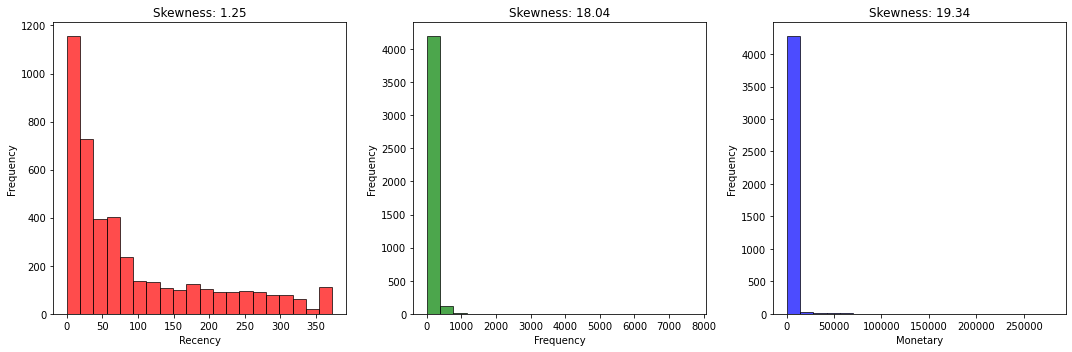

In [17]:
colors = ['red', 'green', 'blue']
columns = ['Recency', 'Frequency', 'Monetary']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    axes[i].hist(rfm[col], color=colors[i], bins=20, edgecolor='black', alpha=0.7)
    skewness = round(rfm[col].skew(), 2)
    axes[i].set_title(f'Skewness: {skewness}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [18]:
#We want to apply log transformation in continuous, transform  0 and negatives to 1 to avoid undefined values.
def to_one(value):
    if value<=0:
        return 1
    else :
        return value

rfm['Monetary']=rfm['Monetary'].apply(to_one)
rfm['Recency']=rfm['Recency'].apply(to_one)
rfm['Frequency']=rfm['Frequency'].apply(to_one)


In [19]:
#Log Transformation for normalization
log_RFM_data=rfm[columns].apply(np.log,axis=1).round(4)
log_RFM_data = log_RFM_data.replace([np.inf, -np.inf], np.nan)

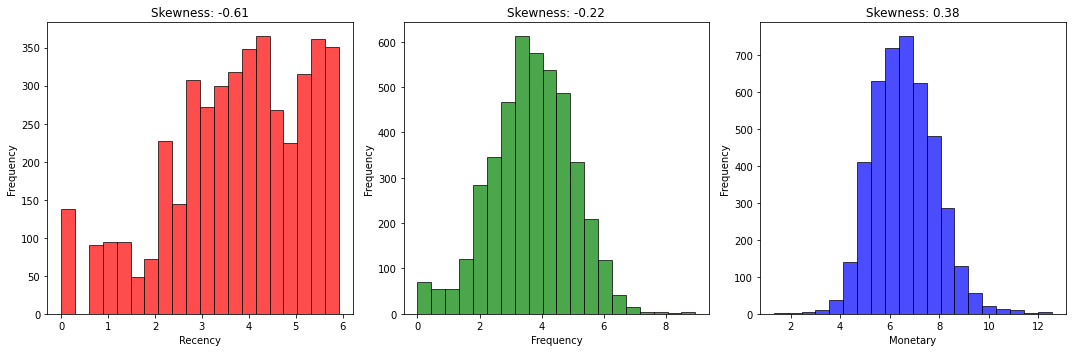

In [20]:
colors = ['red', 'green', 'blue']
columns = ['Recency', 'Frequency', 'Monetary']

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, col in enumerate(columns):
    axes[i].hist(log_RFM_data[col], color=colors[i], bins=20, edgecolor='black', alpha=0.7)
    skewness = round(log_RFM_data[col].skew(), 2)
    axes[i].set_title(f'Skewness: {skewness}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [21]:
log_RFM_data.describe()

,Recency,Frequency,Monetary
count,4338.000000,4338.000000,4338.000000
mean,3.737130,3.671519,6.585704
std,1.474606,1.320856,1.261763
min,0.000000,0.000000,1.321800
25%,2.833200,2.833200,5.725175
50%,3.912000,3.713600,6.505150
75%,4.954050,4.585000,7.414925
max,5.921600,8.945900,12.543300


In [22]:
# # Apply StandardScaler to normalize the features and place them on a standardized scale (mean = 0, standard deviation = 1).
# This step ensures that all features, especially 'Monetary', are on the same scale, improving the performance of machine learning models.
scaler=StandardScaler()
Scaled_RFM_data = scaler.fit_transform(log_RFM_data)
Scaled_RFM_data = pd.DataFrame(Scaled_RFM_data, index=log_RFM_data.index,columns=log_RFM_data.columns)
Scaled_RFM_data

,Recency,Frequency,Monetary
0,1.388103,-2.779971,3.700166
1,-2.064538,1.160352,1.413261
2,0.393622,-0.179843,0.719945
3,-0.574274,0.468675,0.702270
4,1.356091,-0.634751,-0.613026
...,...,...,...
4333,1.279723,-1.036507,-1.101287
4334,0.987408,-1.306590,-1.738644
4335,-1.214857,-0.898474,-1.112543
4336,-1.789518,2.202675,0.822512


In [23]:
Scaled_RFM_data.describe()

,Recency,Frequency,Monetary
count,4.338000e+03,4.338000e+03,4.338000e+03
mean,-1.654330e-16,-1.408637e-16,8.517340e-17
std,1.000115e+00,1.000115e+00,1.000115e+00
min,-2.534616e+00,-2.779971e+00,-4.172344e+00
25%,-6.130682e-01,-6.347515e-01,-6.820837e-01
50%,1.186012e-01,3.186275e-02,-6.384973e-02
75%,8.253459e-01,6.916624e-01,6.572680e-01
max,1.481563e+00,3.993614e+00,4.722187e+00


# K-Means

In [24]:
# Use the Elbow method to find the optimal number of clusters (n_clusters) for the K-Means algorithm.
SS_distance={}
for k in range(2,20):
    model_with_k=KMeans(n_clusters=k,max_iter=500, init='k-means++')
    model_with_k = model_with_k.fit(Scaled_RFM_data)
    SS_distance[k] = model_with_k.inertia_

Text(0.5, 1.0, 'Elbow Techinque to find the optimal cluster size')

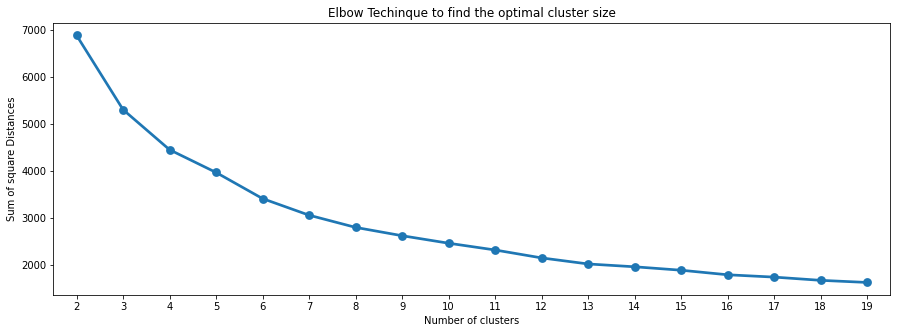

In [25]:
plt.figure(figsize=(15,5))
sns.pointplot(x=list(SS_distance.keys()),y=list(SS_distance.values()))
plt.xlabel("Number of clusters")
plt.ylabel("Sum of square Distances")
plt.title("Elbow Techinque to find the optimal cluster size")

In [26]:
# Initialize the K-Means model with 3 clusters, using 'k-means++' for better centroid initialization.
KM_model =KMeans(n_clusters=3,init='k-means++',max_iter=500)
KM_model.fit(Scaled_RFM_data)

KMeans(max_iter=500, n_clusters=3)

In [27]:
# store Cluster labels.
rfm['Cluster']= KM_model.labels_.astype(str)
rfm['Cluster']= 'Cluster'+rfm['Cluster'] 
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Cluster
0,12346.0,325,1,77183.60,4,4,1,Cluster2
1,12347.0,2,182,4310.00,1,1,1,Cluster0
2,12348.0,75,31,1797.24,4,3,1,Cluster2
3,12349.0,18,73,1757.55,2,1,1,Cluster2
4,12350.0,310,17,334.40,4,4,3,Cluster1


In [28]:
# Perform cluster analysis by calculating the median values of RFM features for each cluster.
cluster_analysis = rfm.groupby('Cluster').median()[['Recency', 'Frequency', 'Monetary']]
print(cluster_analysis)

          Recency  Frequency  Monetary
Cluster                               
Cluster0      8.0      174.0  2969.120
Cluster1    162.0       13.0   238.850
Cluster2     47.0       54.5   860.635


In [29]:
# Rename the clusters based on their madians.
rfm['Cluster'] = rfm['Cluster'].map({'Cluster2': 'Loyal Customer', 'Cluster0': 'Regular Customer',
                                    'Cluster1': 'Dormant Customer'})

In [30]:
rfm.head()

,CustomerID,Recency,Frequency,Monetary,R_Score,F_Score,M_Score,Cluster
0,12346.0,325,1,77183.60,4,4,1,Loyal Customer
1,12347.0,2,182,4310.00,1,1,1,Regular Customer
2,12348.0,75,31,1797.24,4,3,1,Loyal Customer
3,12349.0,18,73,1757.55,2,1,1,Loyal Customer
4,12350.0,310,17,334.40,4,4,3,Dormant Customer


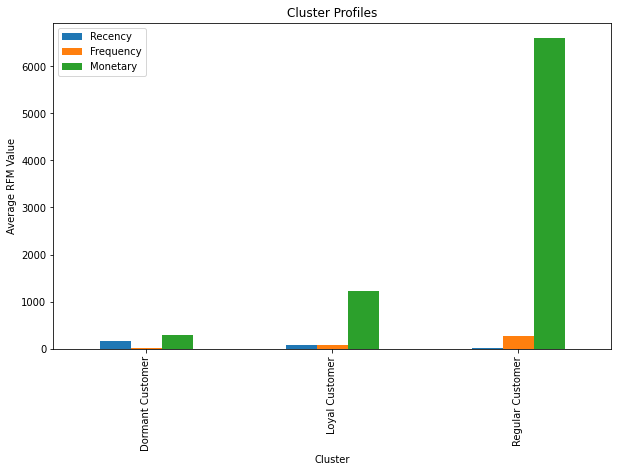

In [31]:
cluster_centers = rfm.groupby('Cluster').mean()[['Recency', 'Frequency', 'Monetary']]
cluster_centers.plot(kind='bar', figsize=(10, 6))
plt.title('Cluster Profiles')
plt.ylabel('Average RFM Value')
plt.xlabel('Cluster')
plt.show()


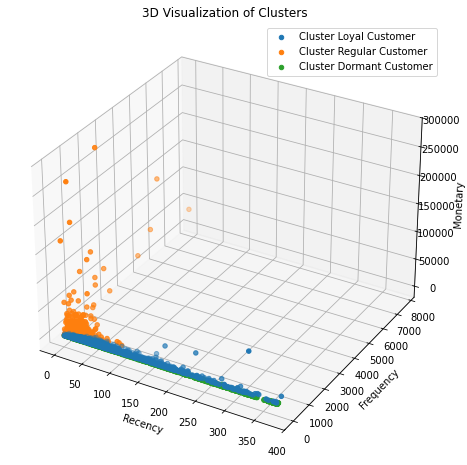

In [32]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

for cluster in rfm['Cluster'].unique():
    cluster_data = rfm[rfm['Cluster'] == cluster]
    ax.scatter(cluster_data['Recency'], cluster_data['Frequency'], cluster_data['Monetary'], label=f'Cluster {cluster}')

ax.set_title('3D Visualization of Clusters')
ax.set_xlabel('Recency')
ax.set_ylabel('Frequency')
ax.set_zlabel('Monetary')
plt.legend()
plt.show()


# KNN

In [33]:
# Define the features (X) and target labels (y) for the KNN.
X=rfm.drop('Cluster',axis=1)
y=rfm['Cluster']

In [34]:
X.drop(['CustomerID'],axis=1,inplace=True)
X.head()

,Recency,Frequency,Monetary,R_Score,F_Score,M_Score
0,325,1,77183.60,4,4,1
1,2,182,4310.00,1,1,1
2,75,31,1797.24,4,3,1
3,18,73,1757.55,2,1,1
4,310,17,334.40,4,4,3


In [35]:
# Split Data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

In [36]:
# Determine the optimal number of neighbors (n_neighbors) for the KNN classifier using GridSearchCV.
param_grid = {'n_neighbors': list(range(1, 31))}

# Initialize the K-Nearest Neighbors (KNN) classifier.
knn = KNeighborsClassifier()

grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
y_pred = best_knn.predict(X_test) 


In [37]:
print(grid_search.best_estimator_)

KNeighborsClassifier(n_neighbors=1)


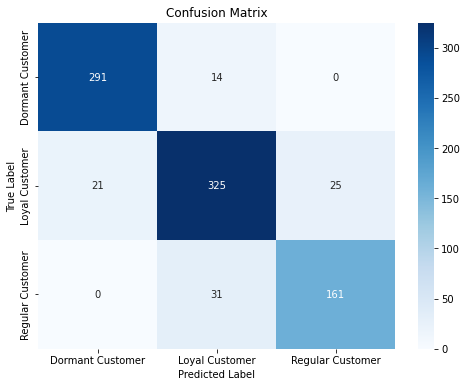

Classification Report:
                  precision    recall  f1-score   support

Dormant Customer       0.93      0.95      0.94       305
  Loyal Customer       0.88      0.88      0.88       371
Regular Customer       0.87      0.84      0.85       192

        accuracy                           0.90       868
       macro avg       0.89      0.89      0.89       868
    weighted avg       0.89      0.90      0.89       868



In [38]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=best_knn.classes_,
            yticklabels=best_knn.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred))
